In [12]:
# load the modules and functions

from functions.storm_interstorm_periods import calc_periods
from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset

from functions.map_plotting import southern_ocean_map

import functions.plot_params

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr
from glob import glob
import cmocean.cm as cmo
import matplotlib.ticker as mticker

from cartopy.util import add_cyclic_point

from tqdm.notebook import tqdm

import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [7]:
# FIGURE 1A: MAP OF THE STORM TRACK DENSITY

In [10]:
# read in the cyclone data

cyclones = xr.open_mfdataset('../data/storms_lodise/ec_centers_1981_2020.nc')

ds_cyclones_summer = cyclones.sel(TIME=cyclones.TIME.dt.season=="DJF")

In [19]:
# load frontal positions

sie = pd.read_csv('../data/seaice/sie.csv').to_xarray().drop('Unnamed: 0')
fronts = pd.read_csv('../data/fronts/ACCfronts.csv').to_xarray().drop('Unnamed: 0')
                  

In [9]:
# create histogram of storm track density during the summer months

storms_hist, x_hist, y_hist, img1 = plt.hist2d(ds_cyclones_summer.LONGITUDE, ds_cyclones_summer.LATITUDE, bins=(180, 45), cmap='afmhot_r')

plt.close()

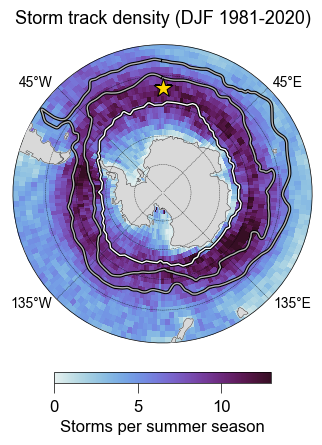

In [24]:
# histogram of the storm track density

fig = plt.figure(figsize=(4, 5))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(x_hist[1:], y_hist[1:], storms_hist.T / 40, cmap=cmo.dense, transform=ccrs.PlateCarree(), vmin=0, vmax=13)

ax.set_title('Storm track density (DJF 1981-2020)', pad=15, fontsize=13)

cb = plt.colorbar(mappable=img, orientation='horizontal', shrink=0.7, pad=0.075)

cb.set_label('Storms per summer season')

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())

plt.savefig('../figs/storm_density.png', dpi=500)

In [26]:
# load the storm and interstorm dataset

ds_storms = xr.open_dataset('/Volumes/LaCie/Work/data/era5/era5_storm_interstorm_periods_1981_2023_DJF.nc')

0it [00:00, ?it/s]

KeyboardInterrupt: 

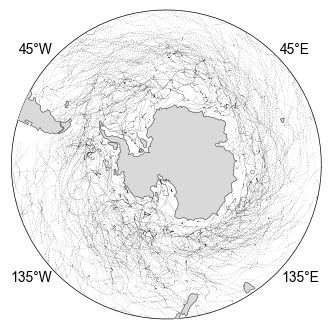

In [25]:
# histogram of the storm track density

fig = plt.figure(figsize=(4, 4.5))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

for i, st in tqdm(enumerate(np.unique(ds_cyclones_summer.STORM_ID))):

    storm = ds_cyclones_summer.isel(TIME=ds_cyclones_summer.STORM_ID.values==st)
    
    img=ax.scatter(storm.LONGITUDE, storm.LATITUDE, s=0.1, lw=0, c='k', alpha=0.3, transform=ccrs.PlateCarree())

ax.set_title('Storm tracks (DJF 1981-2020)', pad=15, fontsize=13)

# plot the glider location as a star

ax.scatter(0, -54, s=150, marker='*', c='gold', edgecolor='k', lw=1, zorder=100, transform=ccrs.PlateCarree())

# # cb = plt.colorbar(mappable=img, orientation='horizontal', shrink=0.8, pad=0.1)

# cb.set_label('No. of cyclones per summer (DJF)')

# ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.5, zorder=100, transform=ccrs.PlateCarree())

# plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/storm_density_tracks.png', dpi=500)

In [5]:
# saved SAF and PF locations from Sokolov and Rintoul (2009)

import scipy.io

mat = scipy.io.loadmat("/Users/xduplm/Google Drive/My Drive/data/fronts/ACCfronts.mat")

XPF  = np.array(list(mat.items())[3][1]).squeeze()
XSAF = np.array(list(mat.items())[4][1]).squeeze()
YPF  = np.array(list(mat.items())[5][1]).squeeze()
YSAF = np.array(list(mat.items())[6][1]).squeeze()

import pandas as pd

XPF  = pd.Series(XPF )
XSAF = pd.Series(XSAF)
YPF  = pd.Series(YPF )
YSAF = pd.Series(YSAF)

window_size = 10

XPF  = XPF .rolling(window=window_size, min_periods=1).mean()
XSAF = XSAF.rolling(window=window_size, min_periods=1).mean()
YPF  = YPF .rolling(window=window_size, min_periods=1).mean()
YSAF = YSAF.rolling(window=window_size, min_periods=1).mean()

In [6]:
# load the sea ice concentration data set

sic_noaa = xr.open_dataset('/Volumes/LaCie/Work/data/sst/noaa/icec.mnmean.nc')

# Step 1: Group by month and calculate the mean
sic_month = sic_noaa.groupby('time.month').mean(dim='time')

# Step 2: Select December values (month=12)
sic_dec = sic_month.sel(month=12).sel(lat=slice(0, -90))

lat_sie = np.ndarray(sic_dec.lon.size)

for i in range(sic_dec.lon.size):

    x = sic_dec.isel(lon=i)

    lat_sie[i] = x.icec[x.icec > 15].lat.max()

In [7]:
# Load the SST datasets

sst_noaa = xr.open_dataset('/Volumes/LaCie/Work/data/sst/noaa/sst.mnmean.nc')
lsm_noaa = xr.open_dataset('/Volumes/LaCie/Work/data/sst/noaa/lsmask.nc')

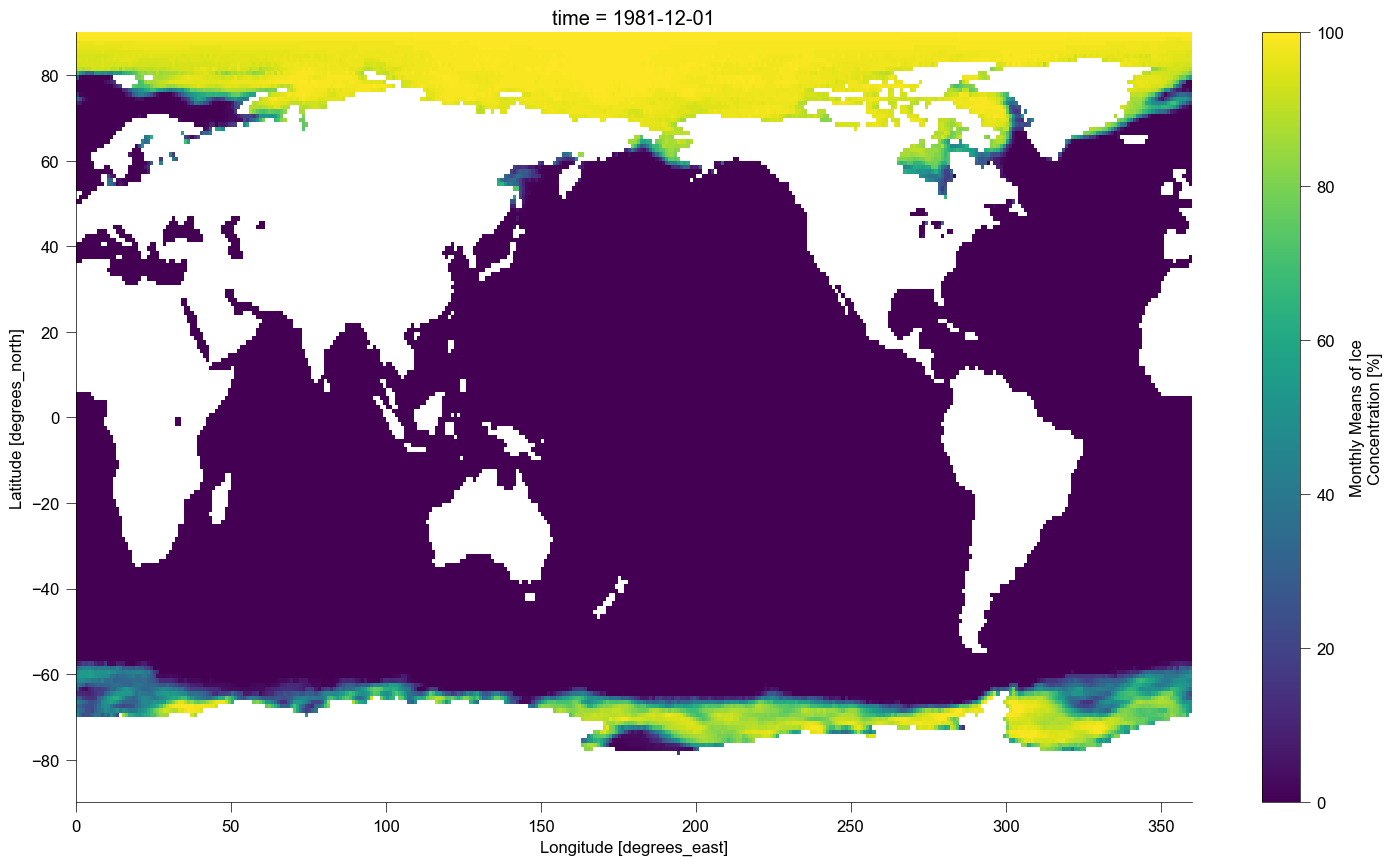

In [24]:
sic_noaa.icec.isel(time=0).plot()

In [9]:
# Mask out where there is sea ice in the sst noaa dataset

import xarray as xr
import numpy as np

# Assuming sic_noaa is your xarray dataset with a variable 'icec'

# Create a mask for datetime values greater than 0
date_mask = sic_noaa.icec < 1

# Create a replacement array with NaN values for the same shape as sic_noaa
# replacement_array = xr.full_like(sic_noaa.icec, fill_value=np.nan, dtype=float)
replacement_array = xr.full_like(sic_noaa.icec, fill_value=np.nan, dtype=float)

# Combine the original data and the replacement array
sic_noaa_filtered = replacement_array.combine_first(sic_noaa.icec.where(date_mask))

sst_noaa_filtered = replacement_array.combine_first(sst_noaa.sst.where(date_mask))


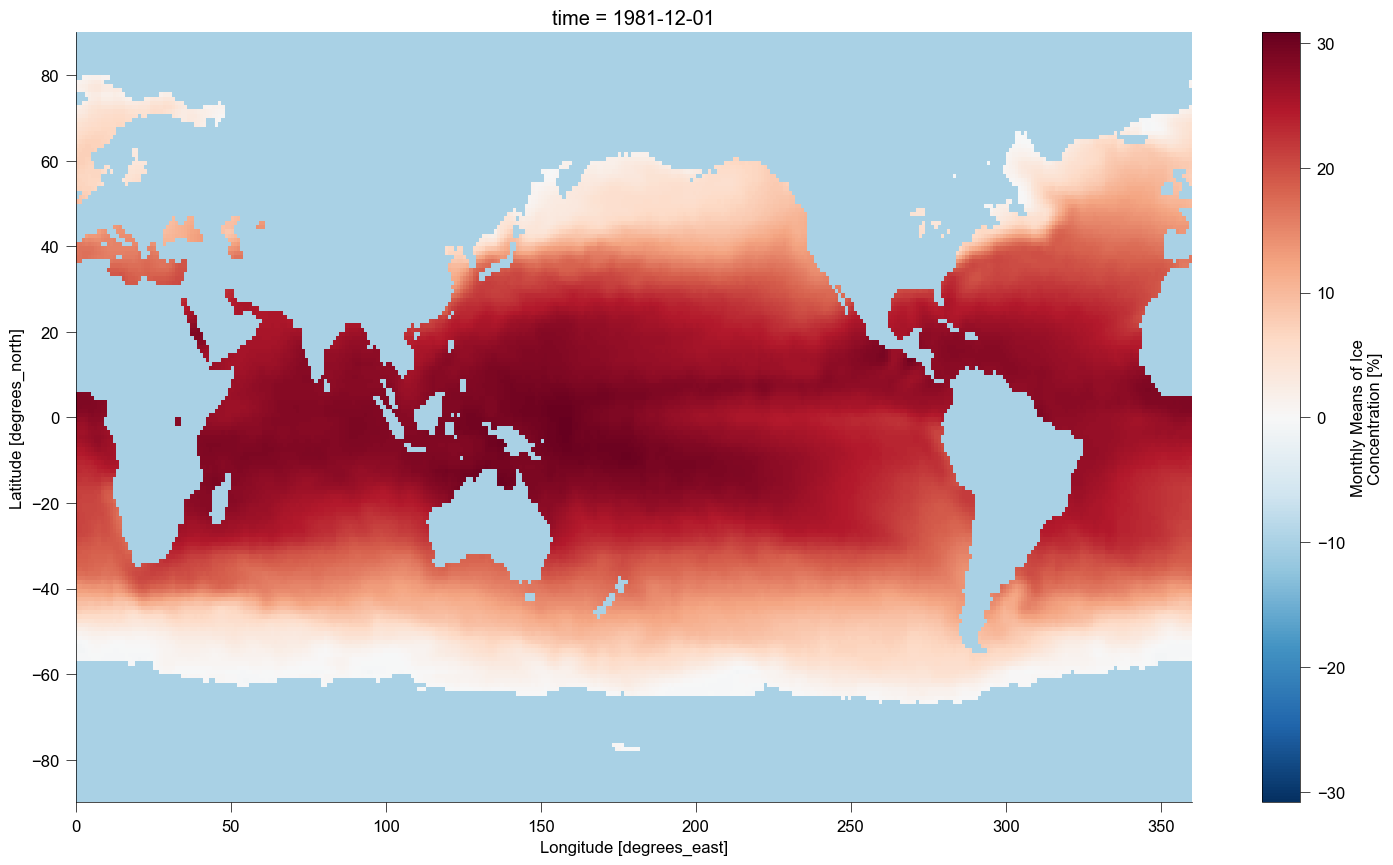

In [26]:
sst_noaa_filtered.where(date_mask, -10).isel(time=0).plot()

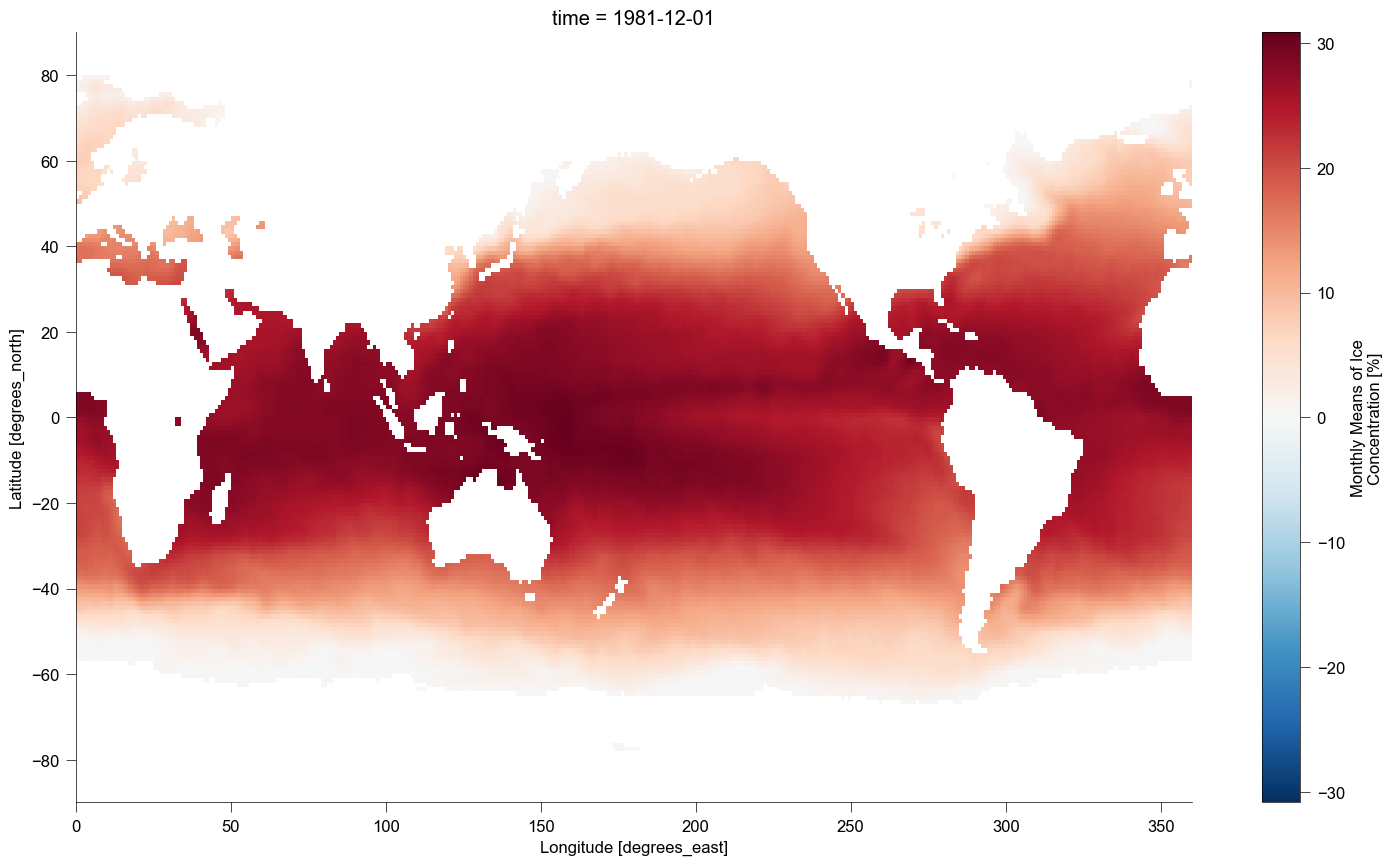

In [27]:
sst_noaa_filtered.isel(time=0).plot()

In [10]:
# filter out only the summer months and calculate seasonal statistics of sst

sst_noaa_filtered['year'] = sst_noaa_filtered['time.year']
sst_noaa_filtered['month'] = sst_noaa_filtered['time.month']

from tqdm.notebook import tqdm

full_idx = np.arange(sst_noaa_filtered.time.size)

years = np.arange(1981, 2022)

sst_noaa_seasonal_mean = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])
sst_noaa_seasonal_max = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])
sst_noaa_seasonal_range = np.ndarray([years.size, sst_noaa_filtered.lat.size, sst_noaa_filtered.lon.size])

for i, year in tqdm(enumerate(years)):

    idx1 = full_idx[((sst_noaa_filtered.year==year)   & (sst_noaa_filtered.month==12))]
    idx2 = full_idx[((sst_noaa_filtered.year==year+1) & (sst_noaa_filtered.month==1))]
    idx3 = full_idx[((sst_noaa_filtered.year==year+1) & (sst_noaa_filtered.month==2))]
    
    idx = np.concatenate((idx1, idx2, idx3))
    
    sst_noaa_seasonal_mean[i]   = sst_noaa_filtered.isel(time=idx).mean(dim='time')
    sst_noaa_seasonal_max[i]    = sst_noaa_filtered.isel(time=idx).max(dim='time')
    sst_noaa_seasonal_range[i]  = sst_noaa_filtered.isel(time=idx).max(dim='time') - sst_noaa_filtered.isel(time=idx).min(dim='time')

    sst_noaa_seasonal_mean[i] = sst_noaa_seasonal_mean[i] * lsm_noaa.mask
    sst_noaa_seasonal_max[i] = sst_noaa_seasonal_max[i] * lsm_noaa.mask
    sst_noaa_seasonal_range[i] = sst_noaa_seasonal_range[i] * lsm_noaa.mask

0it [00:00, ?it/s]

In [11]:
# Create an xarray dataset of only the summer statistics of the sea surface temperature

ds_sst_summer = xr.Dataset(
    {
        'sst_mean': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_mean),
        'sst_max': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_max),
        'sst_range': (['time', 'latitude', 'longitude'], sst_noaa_seasonal_range),
    },
    coords={
        'years': years,
        'latitude': sst_noaa.lat.data,
        'longitude': sst_noaa.lon.data,
    },
)

# Assign units and metadata 

ds_sst_summer['sst_mean'].attrs['units'] = 'degrees Celsius'
ds_sst_summer.attrs['description'] = 'NOAA OI SST V2 SST data DJF seasonal means'

ds_sst_summer = adjust_lon_xr_dataset(ds_sst_summer)

ds_sst_summer = ds_sst_summer.sel(latitude=slice(-40, -90))

years_array = ds_sst_summer.years.data

years = np.array([f'{year}-12-01' for year in years_array], dtype='datetime64')

ds_sst_summer['time'] = (('time'), years)

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_30852/1118724353.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_sst_summer['time'] = (('time'), years)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_30852/1118724353.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the 

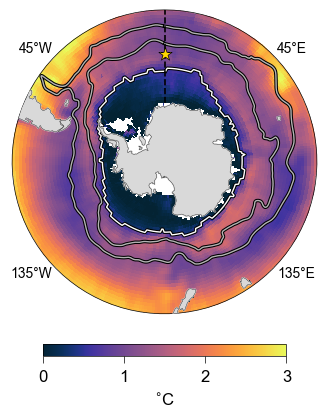

In [12]:
# plot the sst seasonal range

fig = plt.figure(figsize=[3.5, 4.5])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)


img = ax.pcolormesh(ds_sst_summer.longitude, ds_sst_summer.latitude, ds_sst_summer.sst_range.mean(dim='time'), cmap=cmo.thermal, vmin=0, vmax=3, transform=ccrs.PlateCarree())

cb = plt.colorbar(mappable=img, ax=ax, shrink=0.8, pad=0.075, aspect=20, orientation='horizontal')

# ax.set_title('DJF SST$_{max}$ range', pad=15)

cb.set_label('$^{\circ}$C', labelpad=5)

cb.ax.tick_params(axis='both', which='both', width=0.5, length=5)

# plot the fronts 

ax.plot(XSAF, YSAF, lw=2.5, c='k', transform=ccrs.PlateCarree())
ax.plot(XSAF, YSAF, lw=1, c='0.7', transform=ccrs.PlateCarree())

ax.plot(XPF, YPF, lw=2.5, c='k', transform=ccrs.PlateCarree())
ax.plot(XPF, YPF, lw=1, c='0.7', transform=ccrs.PlateCarree())

# plot the sea ice 

ax.plot(sic_dec.lon, lat_sie, c='k', lw=2.5, transform=ccrs.PlateCarree())
ax.plot(sic_dec.lon, lat_sie, c='w', lw=1, transform=ccrs.PlateCarree())

# plot the meridional line

ax.plot([0, 0], [-70, -40], c='k', ls='--', transform=ccrs.PlateCarree())

ax.scatter(0, -54, s=100, marker='*', c='gold', edgecolor='k', lw=0.5, zorder=100, transform=ccrs.PlateCarree())


fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/sst_range_mean_DJF_1981_2023.png', dpi=300, transparent=True)

In [9]:
# cyclone centers

ds_cyclones = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/storms_lodise/ec_centers_2009_2020.nc')

ds_cyclones_summer = ds_cyclones.sel(TIME=ds_cyclones.TIME.dt.season=="DJF")

In [10]:
filtered_dataset = ds_cyclones_summer.where((ds_cyclones_summer.LONGITUDE >= -5) & (ds_cyclones_summer.LONGITUDE <= 5), drop=True)

In [11]:
cyclone_count = np.ndarray([np.arange(-70, -39, 1).size])

for i, x in enumerate(range(-70, -39, 1)):

    subset = filtered_dataset.where((filtered_dataset.LATITUDE >= x) & (filtered_dataset.LATITUDE <= x+1), drop=True)

    cyclone_count[i] = np.unique(subset.STORM_ID).size

In [12]:
# load the storm and interstorm dataset

ds_storms = xr.open_dataset('/Volumes/LaCie/Work/data/era5/era5_storm_interstorm_periods_1981_2023_DJF.nc')

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_21320/663971826.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['70$^{\circ}$S',


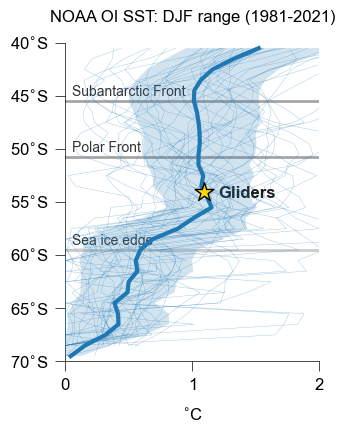

In [21]:
# plot the zonal mean sea surface temperature range

fig,ax = plt.subplots(figsize=(3.5, 4.5))

fig.subplots_adjust(wspace=0.1)

sst_range_mean = ds_sst_summer.sst_range.sel(longitude=0.0, method='nearest').mean(dim='time')
sst_range_std = ds_sst_summer.sst_range.sel(longitude=0.0, method='nearest').std(dim='time')

for i in range(ds_sst_summer.time.size):

    ax.plot(ds_sst_summer.sst_range.sel(longitude=0.0, method='nearest').isel(time=i), ds_sst_summer.latitude, zorder=100, lw=0.25, alpha=0.5, c='tab:blue')

ax.plot(sst_range_mean, ds_sst_summer.latitude, zorder=100, lw=3, c='tab:blue')

ax.fill_betweenx(y=ds_sst_summer.latitude, x1=sst_range_mean-sst_range_std, x2=sst_range_mean+sst_range_std, facecolor='tab:blue', alpha=0.2, zorder=100)

ax.set_ylim(-70, -40)

ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

ax.yaxis.set_ticklabels(['70$^{\circ}$S',
                        '65$^{\circ}$S',
                        '60$^{\circ}$S',
                        '55$^{\circ}$S',
                        '50$^{\circ}$S',
                        '45$^{\circ}$S',
                        '40$^{\circ}$S',
                       ])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.axhline(-54, ls='--', c='gold', lw=2)

ax.axhline(YSAF[0], c='0.3', lw=2, alpha=0.5)
ax.axhline(YPF[0], c='0.3', lw=2, alpha=0.5)
ax.axhline(lat_sie[0], c='0.6', lw=2, alpha=0.5)

ax.set_xlim(0, 2)

ax.xaxis.set_ticks(np.arange(0, 3, 1))

# ax[0].xaxis.set_ticks(np.arange(-20, 120, 50))

ax.set_title('NOAA OI SST: DJF range (1981-2021)', fontsize=12, pad=15)

ax.set_xlabel('$^{\circ}$C', labelpad=10)

# ax.fill_between(x=[-0.2, 3], y1=YSAF.mean()-YSAF.std(), y2=YSAF.mean()+YSAF.std(), facecolor='0.3', alpha=0.2)
# ax.fill_between(x=[-0.2, 3], y1=YPF.mean()-YPF.std(), y2=YPF.mean()+YPF.std(), facecolor='0.3', alpha=0.2)
# ax.fill_between(x=[-0.2, 3], y1=lat_sie.mean()-lat_sie.std(), y2=lat_sie.mean()+lat_sie.std(), facecolor='0.7', alpha=0.2)

ax.text(0.05, -45.0, 'Subantarctic Front', c='0.2', fontsize=10)
ax.text(0.05, -50.3, 'Polar Front', c='0.2', fontsize=10)
ax.text(0.05, -59.0, 'Sea ice edge', c='0.2', fontsize=10)

ax.text(1.2, -54.6, 'Gliders', c='0.1', fontweight='bold')

ax.scatter(1.09, -54, s=200, marker='*', c='gold', edgecolor='k', lw=1, zorder=100)


fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/sst_range_zonal_averages.png', dpi=500, transparent=True)

In [112]:
# load slocum data

sl_sst = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_sst_mean_10m_20231110.nc')
sl_sst = sl_sst.load()

# load the wave glider and the mixing data sets

ep = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_eps_ds_processed_era5_23Sep2022.nc')
wg = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/waveglider/WG_era5_1h_processed_28Aug2022.nc')

xld = pd.read_csv('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/mixing_layer_xld.csv')

xld = xr.Dataset(data_vars=dict(
                                   xld = (['time'], xld.xld.values)),                   
                    coords=dict(
                                time = (['time'], xld.Date.values.astype('datetime64[ns]'))),                   
                    attrs=dict(
                               description="Processed Slocum glider XLD data."))

xld = xld.isel(time=xld.xld>0)

sl_sst = sl_sst.sel(time=slice(xld.time[0].data, xld.time[-1].data))

In [17]:
# load the en4 data

en4 = xr.open_mfdataset('/Users/xduplm/Google Drive/My Drive/data/EN4/soscex_storm/*.nc')

from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset

en4 = adjust_lon_xr_dataset(en4, lon_name='lon')

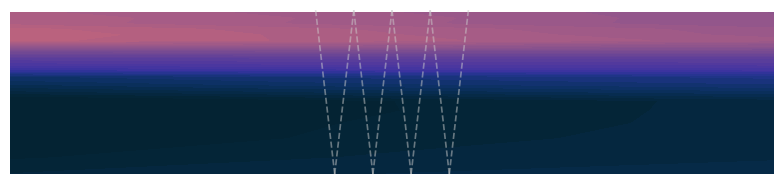

In [174]:
temp_dec = en4.temperature.isel(time=0).sel(lon=0.5, method='nearest')-273.15
temp_feb = en4.temperature.isel(time=2).sel(lon=0.5, method='nearest')-273.15

fig,ax=plt.subplots(figsize=(8, 2))

img=ax.contourf(temp_dec.lat, temp_dec.depth, temp_feb-temp_dec, levels=np.arange(0, 3.05, 0.05), cmap=cmo.thermal, extend='both')

plt.ylim(300, 0)
plt.xlim(-54.5, -53.5)

ax.plot([-54.1, -54.075], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-54.05, -54.075], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-54.05, -54.025], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-54.00, -54.025], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-54.00, -53.975], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-53.95, -53.975], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-53.95, -53.925], [0, 300], ls='--', c='0.8', alpha=0.5)
ax.plot([-53.90, -53.925], [0, 300], ls='--', c='0.8', alpha=0.5)

plt.axis('off')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/figure1_box_meridional.png', dpi=500, transparent=True)

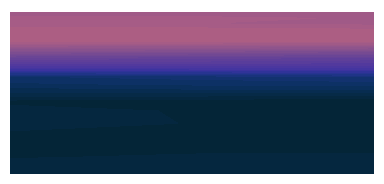

In [147]:
temp_dec = en4.temperature.isel(time=0).sel(lat=-54.5, method='nearest')-273.15
temp_feb = en4.temperature.isel(time=2).sel(lat=-54.5, method='nearest')-273.15

fig,ax=plt.subplots(figsize=(4, 2))

img=ax.contourf(temp_dec.lon, temp_dec.depth, temp_feb-temp_dec, levels=np.arange(0, 3.05, 0.05), cmap=cmo.thermal)

plt.ylim(300, 0)
plt.xlim(-0.5, 0.5)

plt.axis('off')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/figure1_box_zonal.png', dpi=500, transparent=True)

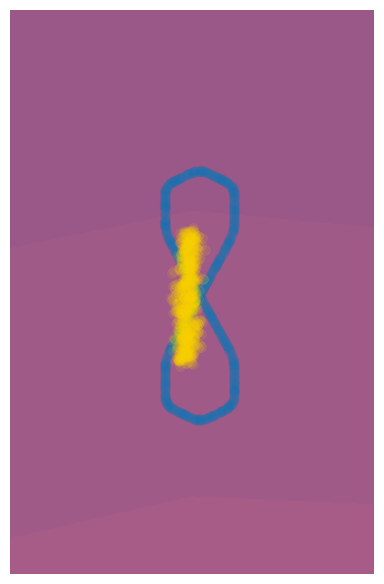

In [158]:
temp_dec = en4.temperature.isel(time=0).sel(depth=0, method='nearest')-273.15
temp_feb = en4.temperature.isel(time=2).sel(depth=0, method='nearest')-273.15

fig,ax=plt.subplots(figsize=(4, 6))

img=ax.contourf(temp_dec.lon, temp_dec.lat, temp_feb-temp_dec, levels=np.arange(0, 3.05, 0.05), cmap=cmo.thermal, extend='both')

plt.ylim(-54.25, -53.75)
plt.xlim(-0.25, 0.25)

plt.axis('off')

ax.scatter(wg.Longitude, wg.Latitude, c='tab:blue', s=50, alpha=0.1, lw=0)
ax.scatter(sl_sst.lon, sl_sst.lat, c='gold', edgecolor='gold', lw=0.5, s=50, alpha=0.1)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/figure1_box_top.png', dpi=300, transparent=True)

In [107]:
# PLOT THE SEASONAL TEMPERATURE RANGE

In [18]:
# calculate the density from the temperature and salinity of the en4 product

import gsw

t = en4.temperature.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15
s = en4.salinity.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)

density = gsw.rho(s, t, en4.depth/1000)

In [19]:
# calculate the mld

import functions.calc_mld as calc_mld

mld = calc_mld.calc_mld(density.T, en4.depth, den_lim=0.03, ref_dpt=10)

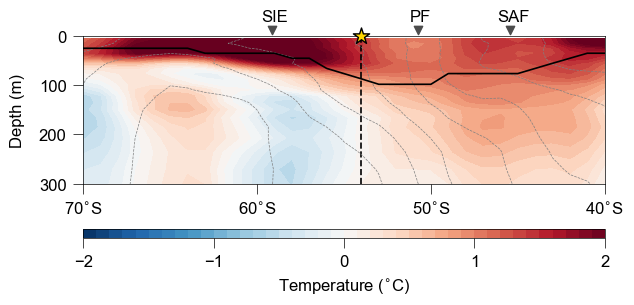

In [44]:
fig,ax = plt.subplots(figsize=(6.5,3.2))

# plot the seasonal temperature range

temp_range = (en4.temperature.sel(time='2019-02-15T00:00:00.000000000', lon=0.0)-273.15) - (en4.temperature.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15)
salt_range = (en4.salinity.sel(time='2019-02-15T00:00:00.000000000', lon=0.0)-273.15) - (en4.salinity.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15)

img=ax.contourf(en4.lat, en4.depth, temp_range, levels=np.arange(-2, 2.1, 0.1), cmap='RdBu_r', extend='both')

plt.colorbar(mappable=img, extendfrac=0, ticks=np.arange(-2, 3, 1), orientation='horizontal', aspect=60, pad=0.2, label='Temperature ($^{\circ}$C)', shrink=1)

# set plot limits

ax.set_xlim(-70, -40)
ax.set_ylim(300, 0)

ax.yaxis.set_ticks(np.arange(0, 400, 100))

# plot glider location

ax.axvline(-54, c='k', ls='--')

ax.scatter(-54, 0, s=150, marker='*', c='gold', edgecolor='k', lw=1, zorder=100, clip_on=False)

# contour the density

ax.contour(en4.lat, en4.depth, density, levels=[1026.3, 1026.5, 1026.7, 1026.9, 1027.1, 1027.3, 1027.5, 1027.7, 1027.9], colors='0.5', linewidths=0.5, linestyles='--')

# plot the mld

ax.plot(en4.lat, mld, c='k')

# add some spines to the plot

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True

# change the xlabels

ax.xaxis.set_ticks(np.arange(-70, -30, 10))
ax.xaxis.set_ticklabels(['70$^{\circ}$S', '60$^{\circ}$S', '50$^{\circ}$S', '40$^{\circ}$S'])

ax.set_ylabel('Depth (m)', labelpad=10)

# set a title

# ax.set_title('Temperature range: Dec 2018 - Feb 2019', fontsize=12, pad=25)

# add the location of the sea ice and the fronts

ax.scatter(np.squeeze(sie_lat[sie_lon==0.5]), -12, marker='v', clip_on=False, label='Sea ice extent', c='0.3')

ax.scatter(YPF[0], -12, marker='v', clip_on=False, label='Polar Front', c='0.3')
ax.scatter(YSAF[0], -12, marker='v', clip_on=False, label='Subantarctic Front', c='0.3')

ax.text(sie_lat[sie_lon==0.5]-0.6, -30, 'SIE', fontsize=12)

ax.text(YPF[0]-0.5, -30, 'PF', fontsize=12)
ax.text(YSAF[0]-0.75, -30, 'SAF', fontsize=12)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/en4_temp_meridional_section.png', dpi=300)

In [319]:
np.squeeze(sie_lat[sie_lon==0.5])

array(-59.16666667)

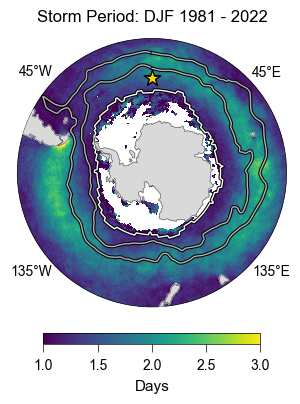

In [14]:
fig = plt.figure(figsize=[4, 4.5])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(ds_storms.longitude, ds_storms.latitude, ds_storms.storm_period.fillna(np.nan).mean(dim='time'), transform=ccrs.PlateCarree(), vmin=1, vmax=3, cmap='viridis')

# ax.contour(ds_storms.longitude, ds_storms.latitude, ds_storms.storm_period.median(dim='time'), transform=ccrs.PlateCarree(), levels=[0, 2, 4, 6], colors='0.7', linewidths=0.1)

props = dict(pad=12, fontsize=12)

ax.set_title('Storm Period: DJF 1981 - 2022', **props)
    
cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)
cb.ax.tick_params(axis='x', which='major', size=6, labelsize=10)
cb.set_label('Days', labelpad=5, fontsize=11)

# cb1.set_ticks([0, 1, 2, 3])

# plot the fronts 

ax.plot(XSAF, YSAF, lw=2.5, c='k', transform=ccrs.PlateCarree())
ax.plot(XSAF, YSAF, lw=1, c='0.7', transform=ccrs.PlateCarree())

ax.plot(XPF, YPF, lw=2.5, c='k', transform=ccrs.PlateCarree())
ax.plot(XPF, YPF, lw=1, c='0.7', transform=ccrs.PlateCarree())

# plot the sea ice 

ax.plot(sic_dec.lon, lat_sie, c='k', lw=2.5, transform=ccrs.PlateCarree())
ax.plot(sic_dec.lon, lat_sie, c='w', lw=1, transform=ccrs.PlateCarree())

# plot the glider box 

ax.scatter(0, -54, s=150, marker='*', c='gold', edgecolor='k', lw=1, zorder=100, transform=ccrs.PlateCarree())


# ax.plot([-10,  10], [-45, -45], c='r', transform=ccrs.PlateCarree())
# ax.plot([ 10, -10], [-60, -60], c='r', transform=ccrs.PlateCarree())

# ax.plot([ 10,  10], [-60, -45], c='r', transform=ccrs.PlateCarree())
# ax.plot([-10, -10], [-60, -45], c='r', transform=ccrs.PlateCarree())

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/storm_periods.png', dpi=300)

In [15]:
idx1 = sic_dec.lon >= 180

idx2 = sic_dec.lon < 180

sie_lon = np.append(sic_dec.lon[idx1].values-360, sic_dec.lon[idx2].values)

sie_lat = np.append(lat_sie[idx1], lat_sie[idx2])

In [16]:
import numpy as np

def circular_running_mean(x, N):
    padded_x = np.concatenate((x[-N+1:], x, x[:N-1]))
    cumsum = np.cumsum(np.insert(padded_x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


sie_lat = circular_running_mean(sie_lat, 3)[1:-1]

In [266]:
sie_lat.size

360

In [17]:
interstorm_per_mean_noice = ds_storms.interstorm_period.fillna(np.nan).mean(dim='time')

for i, lon in enumerate(interstorm_per_mean_noice.longitude.values):

    idx = np.argmin(np.abs(lon-sie_lon))

    idx_to_nan = interstorm_per_mean_noice.latitude < sie_lat[idx]

    interstorm_per_mean_noice[idx_to_nan,i] = np.NaN
    

In [268]:
import glidertools as gt

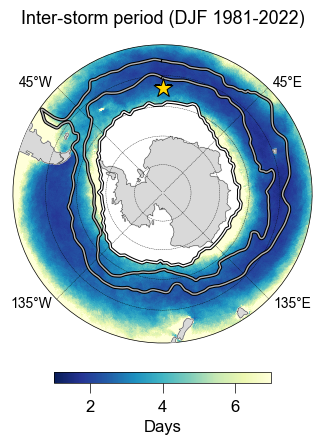

In [61]:
fig = plt.figure(figsize=(4, 5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(ds_storms.longitude, ds_storms.latitude, interstorm_per_mean_noice, transform=ccrs.PlateCarree(), vmin=1, vmax=7, cmap='YlGnBu_r')

# ax.contour(ds_storms.longitude, ds_storms.latitude, ds_storms.storm_period.median(dim='time'), transform=ccrs.PlateCarree(), levels=[0, 2, 4, 6], colors='0.7', linewidths=0.1)

props = dict(pad=15, fontsize=13)

ax.set_title('Inter-storm period (DJF 1981-2022)', **props)
    
cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)
# cb.ax.tick_params(axis='x', which='major', size=6, labelsize=10)
cb.set_label('Days')

# cb1.set_ticks([0, 1, 2, 3])

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(XSAF, YSAF, lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(XSAF, YSAF, lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(XPF, YPF, lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(XPF, YPF, lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie_lon, sie_lat, c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie_lon, sie_lat, c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/interstorm_periods.png', dpi=300)

In [75]:
sst_noaa = xr.open_dataset('/Volumes/LaCie/Work/data/sst/noaa/sst.mnmean.nc')

sst_noaa = adjust_lon_xr_dataset(sst_noaa, lon_name='lon')


In [98]:
sst_clim = sst_noaa.groupby('time.season').mean().sel(season='DJF').sst
sst_2019 = sst_noaa.sel(time=slice('2018-12-01', '2019-02-01')).mean(dim='time').sst

sst_anom = sst_2019 - sst_clim

sst_min = sst_noaa.sel(time=slice('2018-12-01', '2019-02-01')).min(dim='time').sst
sst_max = sst_noaa.sel(time=slice('2018-12-01', '2019-02-01')).max(dim='time').sst

sst_range = sst_max - sst_min

In [252]:
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True

In [192]:
lon_sie = ((sic_dec.lon + 180) % 360) - 180

XSAF = ((XSAF + 180) % 360) - 180
XPF = ((XPF + 180) % 360) - 180

In [193]:
XPF = np.concatenate([XPF[804:], XPF[:804]])
XSAF = np.concatenate([XSAF[754:], XSAF[:754]])
lon_sie = np.concatenate([lon_sie[180:], lon_sie[:180]])

YPF = np.concatenate([YPF[804:], YPF[:804]])
YSAF = np.concatenate([YSAF[754:], YSAF[:754]])
lat_sie = np.concatenate([lat_sie[180:], lat_sie[:180]])

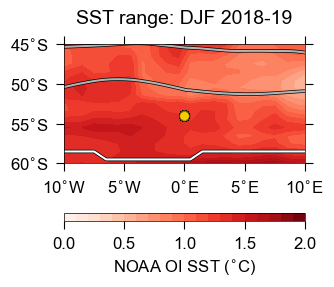

In [253]:
fig,ax=plt.subplots(figsize=(3.5, 3))

img = ax.contourf(sst_anom.lon, sst_anom.lat, sst_range, cmap='Reds', levels=np.arange(0, 2.1, 0.1))

cb = plt.colorbar(mappable=img, orientation='horizontal', aspect=30, pad=0.25)

cb.set_ticks(np.arange(0, 2.5, 0.5))
cb.ax.tick_params(axis='x', which='major', size=6, labelsize=12)

cb.set_label('NOAA OI SST ($^{\circ}$C)')

ax.scatter(wg.Longitude, wg.Latitude, c='k', s=30, alpha=0.1)
ax.scatter(sl_sst.lon, sl_sst.lat, c='gold', edgecolor='k', lw=0.5, s=50, alpha=0.1)

ax.set_xlim(-10, 10)
ax.set_ylim(-60, -45)

ax.xaxis.set_ticks(np.arange(-10, 15, 5))
ax.xaxis.set_ticklabels(['10$^{\circ}$W', '5$^{\circ}$W', '0$^{\circ}$E', '5$^{\circ}$E', '10$^{\circ}$E'])

ax.yaxis.set_ticks(np.arange(-60, -40, 5))
ax.yaxis.set_ticklabels(['60$^{\circ}$S',
                         '55$^{\circ}$S',
                         '50$^{\circ}$S',
                         '45$^{\circ}$S'
                        ])

plt.tick_params(axis='both', which='both', direction='out', bottom=True, top=True, left=True, right=True, size=6)

ax.set_title('SST range: DJF 2018-19', pad=15, fontsize=14)

# plot the sea ice 

ax.plot(lon_sie, lat_sie, c='k', lw=2.5)
ax.plot(lon_sie, lat_sie, c='w', lw=1.5)

# plot the fronts 

ax.plot(XSAF, YSAF, lw=2.5, c='k')
ax.plot(XSAF, YSAF, lw=1.5, c='0.7')

ax.plot(XPF, YPF, lw=2.5, c='k')
ax.plot(XPF, YPF, lw=1.5, c='0.7')


fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/slocum_loc.png', dpi=300)

In [227]:
# determine the day of year variable for hte various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

sl_sst['DOY']=(('time'), mdates.date2num(sl_sst.time)-day0)
ep['DOY']=(('time'), mdates.date2num(ep.TIME)-day0)
xld['DOY']=(('time'), mdates.date2num(xld.time)-day0)

In [255]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

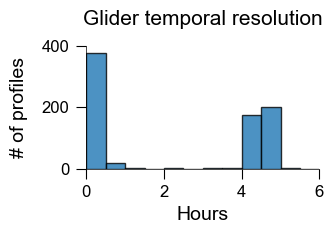

In [264]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(sl_sst.DOY.diff(dim='time')*24, bins=np.arange(0, 6.5, 0.5), edgecolor='k', alpha=0.8)

ax.set_xlim(0, 6)
ax.set_ylim(0, 400)

ax.set_xlabel('Hours', fontsize=14)

ax.set_ylabel('# of profiles', labelpad=10, fontsize=14)

ax.set_title('Glider temporal resolution', pad=15, fontsize=15)

fig.tight_layout()


plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/slocum_time_res.png', dpi=300)